# Histopathologic Cancer Detection using a CNN Architecture

In this demo I will classify Cancer Cells using a basic CNN architecture. The overall data folder is ignored by the gitignore because it conteins around 7 GB of Data in images. To download it you need to access the [Kaggle Learning Contest](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview). Right now, the constest is alredy finished, so it is not possible to access the leaderboard. But for this problem, I achieved a 0.7878 score for the private leaderboard and 0.8395 for the public one, giving me a place of around 1000.

## Used Architecture

For this demo, I trained my model in a Pop-OS 22.04 using an ASUS TUF F17 Gaming Computer with 4 GB of Graphic memory in its NVIDIA GeForce RTX 3050.

## Initial imports

First I'll import some starting libraries, I will use PyTorch instead of Keras because some issues I have installing it with conda and cuda integration with my system.

In [8]:
import os
import cv2
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from tqdm import tqdm

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from glob import glob

## CUDA Installation Validation

The following code shows if the training device is located in the GPU, the desired output needs to contain the word 'cuda' and it has it.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Dataset Loading

Then, I will load the train dataset information.

In [3]:
df_train = pd.read_csv("../data/train_labels.csv")
id_label_map = {k:v for k,v in zip(df_train.id.values, df_train.label.values)}
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### Counting the Cancer / not Cancer images

In the following cell the '1' label count shows the Cancer images the dataset has, while the '0' label shows the not Cancer ones.

In [4]:
df_train.label.value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

## Image visualiztion

The following cells segments the Cancer/non-Cancer image names and visualize them using the show_figure function.

In [5]:
zero_portion = df_train[df_train['label'] == 0]
ones_portion = df_train[df_train['label'] == 1]

In [11]:
def show_figure(path):
    img = mpimg.imread(path)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

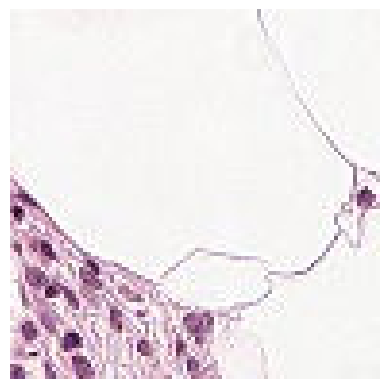

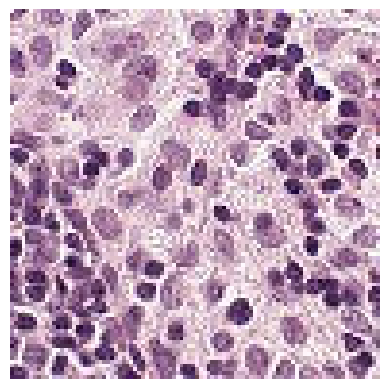

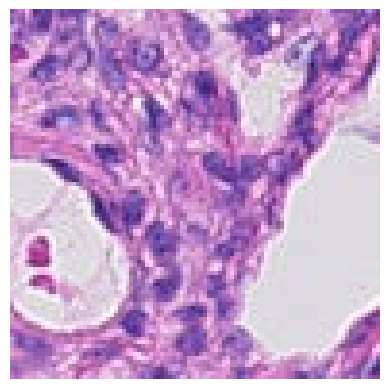

In [13]:
for it, row in zero_portion.head(3).iterrows():
    show_figure(f'../data/train/{row["id"]}.tif')

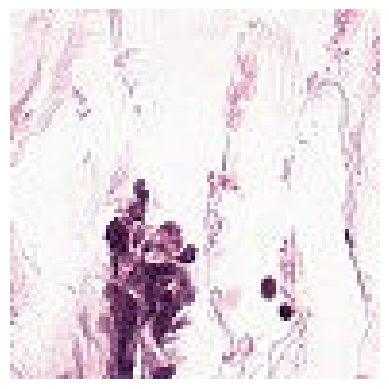

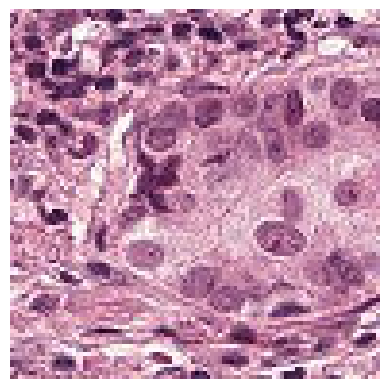

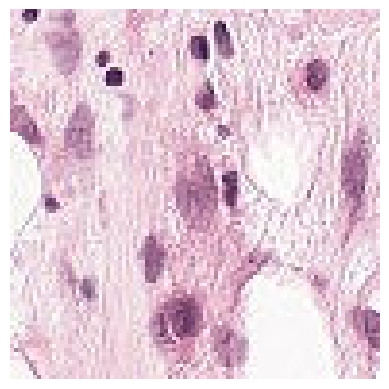

In [14]:
for it, row in ones_portion.head(3).iterrows():
    show_figure(f'../data/train/{row["id"]}.tif')

At the first sigth, it seems the cancer cells are darker than the non-cancer cells. Usually a traditional computer vision alternative will achieve a good score, but not a state-of-the-art one.

## Some insights about the testing data

I decided to count the actual .tif extension files in the training/testing folders just for educational reasons. The objective of the contest is to categorize the test files (around 57458 ones). Which is a pretty large quantity.

In [5]:
labeled_files = glob('../data/train/*.tif')
test_files = glob('../data/test/*.tif')

In [6]:
print("labeled_files size :", len(labeled_files))
print("test_files size :", len(test_files))

labeled_files size : 220025
test_files size : 57458


## Train / Validation Splitting

I need to train the model using a similar methodology that Keras uses with the validation data portion. Looking to improve the score, the validation data portion will be 10%.

In [7]:
train, val = train_test_split(df_train, test_size=0.1, random_state=42)

## Loading images in memory

Here some tricks for data loading. First, the apply method in the following three cells will load the images much faster than a sequential method using a for or while loop.

In [8]:
def map_images(row):
    image_path = os.path.join("../data/train/", row['id'] + ".tif")
    image = cv2.imread(image_path)
    return image

In [9]:
train_X = list(train.apply(map_images, axis=1))
train_y = list(train['label'])

In [10]:
valid_X = list(val.apply(map_images, axis=1))
valid_y = list(val['label'])

Then, I need to see what size are the images because in PyTorch you need to do some mathematics for the actual size of each layer passing through the CNN model.

In [11]:
train_X[0].shape

(96, 96, 3)

Next, an additional hint is to and only to convert the image in a tensor only when is loaded to the CNN. This because, even I have 32 GB of RAM in my laptop, if you load with the previous apply function the images in tensor format, it will fill all your memory and the project will not run. As simple as that.

In [12]:
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = torch.tensor(self.data[index], dtype=torch.float32).permute(2, 0, 1).to(device)
        y = torch.tensor(self.targets[index], dtype=torch.float32).unsqueeze(0).to(device)
        return x, y


## Model Building

Remember when I mention, for PyTorch you need to know some basic mathematics. If you see the self.fc1 layer, you will see 256 kernels of size 6 x 6, this because you are pooling the image four times after each convolution step. If the image is of size 96x96x3, after the first convolution of pardding 1 the size is the same but after the pooling the size divides by two. Then again, again and again, giving you a final image of size 6x6 with 256 kernels.

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 6 * 6, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(-1, 256 * 6 * 6)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))
        return x

Finally, I create a CustomDataset with the training portions...

In [14]:
train_dataset = CustomDataset(train_X, train_y)
valid_dataset = CustomDataset(valid_X, valid_y)

And, then passing them to DataLoaders for easy to use loading object in the training step.

In [15]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

## Model Training

Then, I create the CNN and allocate it in my GPU. Also give the Loss criterion and Adam Optimizer. 

In [18]:
model = CNN().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Finally, looking to get the best model through all the epochs, I create an hardcode early stopping step with patience 3.

In [19]:
best_loss = float('inf')
patience = 3
counter = 0

And then, training the model and evaluating it using the validation set.

In [20]:
for epoch in range(100): 
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_dataloader, 0), f'Training EPOCH {epoch}'):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        torch.cuda.empty_cache() 
    train_loss = running_loss / len(train_dataloader)
    print('Epoch %d, Training loss: %.3f' % (epoch + 1, train_loss))

    model.eval() 
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(valid_dataloader, f'Valid EPOCH {epoch}: '):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        torch.cuda.empty_cache() 

    valid_loss /= len(valid_dataloader)
    accuracy = 100 * correct / total
    print('Epoch %d, Validation loss: %.3f, Accuracy: %.2f %%' % (epoch + 1, valid_loss, accuracy))

    # Early stopping
    if valid_loss < best_loss:
        torch.save(model.state_dict(), './../model/best_model.pth') 
        best_loss = valid_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print('Early stopping at epoch %d' % (epoch + 1))
            break

print('Finished Training')

Training EPOCH 0: 0it [00:00, ?it/s]/home/reikia/anaconda3/envs/cnn-project/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Training EPOCH 0: 6189it [02:29, 41.43it/s]


Epoch 1, Training loss: 0.468


Valid EPOCH 0: 100%|█████████████████████████| 688/688 [00:04<00:00, 155.68it/s]


Epoch 1, Validation loss: 0.404, Accuracy: 82.46 %


Training EPOCH 1: 6189it [02:28, 41.71it/s]


Epoch 2, Training loss: 0.419


Valid EPOCH 1: 100%|█████████████████████████| 688/688 [00:04<00:00, 159.34it/s]


Epoch 2, Validation loss: 0.414, Accuracy: 82.55 %


Training EPOCH 2: 6189it [12:43,  8.11it/s]


Epoch 3, Training loss: 0.389


Valid EPOCH 2: 100%|██████████████████████████| 688/688 [00:34<00:00, 19.93it/s]


Epoch 3, Validation loss: 0.368, Accuracy: 83.58 %


Training EPOCH 3: 6189it [07:19, 14.08it/s]


Epoch 4, Training loss: 0.369


Valid EPOCH 3: 100%|█████████████████████████| 688/688 [00:04<00:00, 156.41it/s]


Epoch 4, Validation loss: 0.347, Accuracy: 84.90 %


Training EPOCH 4: 6189it [02:29, 41.40it/s]


Epoch 5, Training loss: 0.362


Valid EPOCH 4: 100%|█████████████████████████| 688/688 [00:04<00:00, 155.70it/s]


Epoch 5, Validation loss: 0.349, Accuracy: 86.82 %


Training EPOCH 5: 6189it [02:29, 41.27it/s]


Epoch 6, Training loss: 0.368


Valid EPOCH 5: 100%|█████████████████████████| 688/688 [00:04<00:00, 155.55it/s]


Epoch 6, Validation loss: 0.354, Accuracy: 85.77 %


Training EPOCH 6: 6189it [02:29, 41.42it/s]


Epoch 7, Training loss: 0.358


Valid EPOCH 6: 100%|█████████████████████████| 688/688 [00:04<00:00, 156.09it/s]

Epoch 7, Validation loss: 0.359, Accuracy: 86.38 %
Early stopping at epoch 7
Finished Training


## Creating the submission file

Here as you can see in the training step, the model produces an accuracy of around 86%, which is the desired one in the submission. I saved the best model giving the validation loss, and in the next cell, I load it using the previous defined architecture. 

In [21]:
model = CNN().to(device)
model.load_state_dict(torch.load('./../model/best_model.pth', map_location=device))

<All keys matched successfully>

And last but not least, I started predicting the images in the testing dataset and saving it in a csv for the Kaggle contest.

In [22]:
id_names = []
id_labels = []
folder_path = './../data/test/'

for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        img = cv2.imread(os.path.join(folder_path, filename))
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).to(device)
        
        model.eval()
        with torch.no_grad():
            output = model(img)
            predicted_label = 1 if output.item() > 0.5 else 0  # Suponiendo que tienes una clasificación binaria

        id_names.append(os.path.splitext(filename)[0])
        id_labels.append(predicted_label)

        torch.cuda.empty_cache()

df = pd.DataFrame({'id': id_names, 'label': id_labels})

In [24]:
df.to_csv('./../results/results.csv', index=False)

## Conclussions

For this demo, I trained a basic CNN architecture for the [Kaggle Learning Contest](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview) of Cancer classification. I achieved a score of 0.7878 in the private data portion and a 0.8395 in the public one which parsed to the leaderboard will give a place of around 1000. In future works it is possible to increase the fully connected layers and give different kernel sizes looking to improve the performance.